In [1]:
%matplotlib inline
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from joblib import Parallel, delayed
from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import trange
import contextlib
import joblib
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import edward2 as ed
import tensorflow as tf
from scipy.special import digamma
from pickle import dump, load
from scipy.sparse import csr_matrix
import tensorflow_probability as tfp
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import os
import sys
import time

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tensorflow does not work with new numpy versions
assert np.__version__  < '1.20'



/home/iron/Repositories/classes/ml_2_classes/ML2_Exercises/pgm/ex7/denys/LDA_nips_papers/.env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
tqdm.pandas()

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/iron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# data_proc = pd.read_pickle('data_proc.pkl')
# data_enc = pd.read_pickle('data.pkl')
# with open('word_to_idx.pkl', 'rb') as f:
#     words_to_idx = load(f)

In [5]:
n = 50
seed = 42
data = pd.read_csv('nips-papers/papers.csv')
data = data[['paper_text']]
data_n = data.sample(n=n, random_state=42)

In [6]:
# data_n.head()

In [7]:
def func(text):
    text = text.lower()
    text = re.sub(r'(\d+)', '', text)
    text = re.sub(r'(\n)|(\t)', ' ', text)
    text = text.translate({ ord(c): None for c in string.punctuation })
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    text = [i for i in tokens if not i in stop_words and len(i) > 1]
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

In [8]:
data_proc = data_n['paper_text'].progress_apply(func)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
data_proc.head()

509     [independent, component, analysis, identificat...
2576    [nearmaximum, entropy, model, binary, neural, ...
6362    [nearestneighbor, sample, compression, efficie...
6173    [efficient, highorder, interactionaware, featu...
6552    [multioutput, polynomial, network, factorizati...
Name: paper_text, dtype: object

In [10]:
# words_to_idx = {}
# idx_to_word = {}
# def encode(text, words_to_idx, idx_to_word):
#     text_enc = np.empty(len(text), dtype=int)
#     for i, word in enumerate(text):
#         if word not in words_to_idx:
#             idx = words_to_idx[word] = len(words_to_idx)
#             idx_to_word[idx] = word
#         else:
#             idx = words_to_idx[word]
#         text_enc[i] = idx
#     return text_enc
# data_enc = data_proc.progress_apply(encode, args=(words_to_idx, idx_to_word))

In [11]:
def encode2(text, word_dict):
    return np.asarray(word_dict.doc2idx(text))

word_dict = Dictionary(data_proc)
data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
# data_proc.to_pickle('data_proc.pkl')
# data_enc.to_pickle('data.pkl')

# with open('word_to_idx.pkl', 'wb') as f:
#     dump(words_to_idx, f)

In [13]:
data_train = data_enc.iloc[:n]
# data_test = data_enc.iloc[n:]

K = 5
D = len(data_train)
Ns = data_train.apply(lambda x: len(x)).to_numpy().astype(np.int)
N = Ns.sum()
V = len(word_dict)

In [14]:
print(K, D, Ns, N, V)

5 50 [1473 2453 3310 3107 3017 1621 1727 1618 3434 1774 1454 1339 2501 1669
 1785 1426 1956 2017 2192 1927 2614 2839 1642 2324 1934 3103 3264 2957
 2776 1736 3298 2756 1244 1501 1855 1112 1979 2687 1972 2950 2946 2881
 2925 2306 2767 3010 1629 1468 2904 1105] 112284 12119


In [15]:
def create_sparse(data, alpha, D, K, V):
    Ns = np.empty(D, dtype=np.int)
     
    for i, doc in enumerate(data):
        Ns[i] = len(doc)
    
    N = Ns.sum()
    rows = np.empty(N, dtype=np.int64)
    cols = np.empty(N, dtype=np.int64)
    v_cols = np.empty(N, dtype=np.int64)
    
    last_idx = 0
    
    for i, doc in tqdm(enumerate(data), total=D):
        n = len(doc)
        rows[last_idx:last_idx+n] = i
        cols[last_idx:last_idx+n] = np.arange(n, dtype=np.int64)
        v_cols[last_idx:last_idx+n] = doc
        last_idx += n
        
    N_max = Ns.max()
    phi_rows = np.repeat(rows, K)
    phi_cols = np.repeat(cols, K)
    phi3 = np.tile(np.arange(K), len(rows))  
    phi_indices = np.vstack((phi_rows, phi_cols, phi3)).T
    phi = tf.sparse.SparseTensor(phi_indices, values=tf.fill((len(phi_indices),), 1/K), dense_shape=(D, N_max, K))
    phi = tf.sparse.reorder(phi)
    gamma_v_cols = np.repeat(v_cols, K)
    gamma = tf.expand_dims(alpha, 0) + (Ns / K).reshape(-1, 1)

    beta_indices = np.vstack((phi3, gamma_v_cols)).T
    gamma_indices = np.vstack((phi_rows, phi3)).T
    w_indices = np.vstack((phi_rows, phi_cols, phi3, gamma_v_cols)).T
    tmp = tf.sparse.SparseTensor(w_indices, phi.values, dense_shape=(D, N_max, K, V))
    tmp = tf.sparse.reorder(tmp)
    w_indices = tmp.indices
    lmbd = tf.fill((K, V), 1/V)
    return phi, gamma, lmbd, tf.constant(beta_indices, dtype=tf.int64), tf.constant(gamma_indices, dtype=tf.int64), tf.constant(w_indices, dtype=tf.int64), N_max

In [16]:
# alpha_n = np.random.rand(K).astype(np.float32)
# eta_n = np.random.rand(1).astype(np.float32)
# beta_n = np.random.dirichlet(np.random.rand(V).astype(np.float32), size=K).astype(np.float32)
# phi_n = [np.full((n, K), 1/K).astype(np.float32) for n in Ns]
# gamma_n = alpha_n.reshape(1, -1) + Ns.reshape(-1, 1) / K
# gammma_n = gamma_n.astype(np.float32)
# lmbd_n = np.full((K, V), eta_n)
# lmbd_n = lmbd_n.astype(np.float32)

In [17]:
# It tries to estimate also smoothed params, but eta tends to go negative, breaking all the stuff.
# Maybe loss is incorrect

class Positive(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.math.greater(w, 0.), w.dtype)   
    
@tf.function
def calc_elbo(alpha, beta, eta, phi, gamma, lmbd, w_indices, D, K, N_max, V):
    digamma = tf.math.digamma(gamma) - tf.math.digamma(tf.math.reduce_sum(gamma, axis=1, keepdims=True))
    ta = tf.math.lgamma(tf.math.reduce_sum(alpha)) - \
                                          tf.math.reduce_sum(tf.math.lgamma(alpha)) + \
                                          tf.math.reduce_sum(tf.expand_dims(alpha - 1, 0)*digamma, axis=1)
    zt = tf.sparse.reduce_sum(tf.expand_dims(digamma, 1)*phi, axis=(1, 2))
    wzb = tf.math.reduce_sum(tf.expand_dims(tf.math.log1p(beta), axis=0) * tf.sparse.reduce_sum(tf.SparseTensor(w_indices, phi.values, dense_shape=(D, N_max, K, V)), axis=(1)), axis=(1, 2))
    bl = tf.math.reduce_sum((eta-1)*tf.math.reduce_sum(tf.math.digamma(lmbd) - tf.math.digamma(tf.math.reduce_sum(lmbd, axis=1, keepdims=True)), axis=1) + \
         tf.math.lgamma(eta*V) - V*tf.math.lgamma(eta))
    qt = -tf.math.lgamma(tf.math.reduce_sum(gamma, axis=1)) + tf.math.reduce_sum(tf.math.lgamma(gamma), axis=1) - tf.math.reduce_sum((gamma-1)*digamma, axis=1)
    phi_log_phi = tf.sparse.SparseTensor(phi.indices, phi.values*tf.math.log1p(phi.values), dense_shape=[D, N_max, K])
    qz = tf.sparse.reduce_sum(phi_log_phi, axis=(1, 2))
    elbo = tf.math.reduce_sum(ta + zt + qt + qz)
    return elbo

@tf.function
def e_step_it(alpha, beta_mod, eta, phi, gamma, lmbd, gamma_indices, w_indices, D, K, N_max, V):
    # phi
    dg = tf.math.exp(tf.math.digamma(gamma) - tf.math.digamma(tf.math.reduce_sum(gamma, axis=1, keepdims=True)))
    phi = tf.sparse.SparseTensor(phi.indices, beta_mod*tf.gather_nd(dg, gamma_indices), dense_shape=[D, N_max, K])
    phi /= tf.sparse.reduce_sum(phi, axis=2, keepdims=True) + 1e-5
    # gamma
    gamma = tf.expand_dims(alpha, 0) + tf.sparse.reduce_sum(phi, axis=1)
    # lambda
    lmbd = eta + tf.sparse.reduce_sum(tf.SparseTensor(w_indices, phi.values, dense_shape=(D, N_max, K, V)), axis=(0, 1))
    
    gamma.set_shape((D, K))
    lmbd.set_shape((K, V))
    return phi, gamma, lmbd

@tf.function
def e_step(alpha, beta, eta, phi, gamma, lmbd, beta_indices, gamma_indices, w_indices, D, K, N_max, V, max_it=1000, rtol=1e-03, atol=1e-03):      
    beta_mod = tf.gather_nd(beta, beta_indices)

    np_isclose = lambda elbo_old, elbo: np.allclose(elbo_old, elbo, rtol=rtol, atol=atol)
    tf_cond = lambda i, elbo_old, elbo, args: tf.logical_and(i < max_it, tf.logical_or(i == 0, tf.logical_not(tf.numpy_function(np_isclose, [elbo_old, elbo], tf.bool))))
    
    @tf.function
    def tf_body(i, elbo_old, elbo, args):
        phi, gamma, lmbd = args
        i = i + 1
        elbo_old = tf.identity(elbo)
        phi, gamma, lmbd = e_step_it(alpha, beta_mod, eta, phi, gamma, lmbd, gamma_indices, w_indices, D, K, N_max, V)
        elbo = calc_elbo(alpha, beta, eta, phi, gamma, lmbd, w_indices, D, K, N_max, V)
        args = (phi, gamma, lmbd)
        return (i, elbo_old, elbo, args)
    
    i = tf.constant(0, name='e_loop_counter')
    elbo = tf.constant(np.inf, dtype=tf.float32)
    elbo_old = tf.identity(elbo)
    args = (phi, gamma, lmbd)
    
    i, _, elbo, args = tf.while_loop(tf_cond, tf_body, [i, elbo_old, elbo, args], parallel_iterations=1)
    phi, gamma, lmbd = args
    return phi, gamma, lmbd

@tf.function
def m_step(alpha, alpha_2, beta, eta, phi, gamma, lmbd, w_indices, D, K, N_max, V, opt, max_it=1000, rtol=1e-03, atol=1e-03):
    # beta
    beta = tf.sparse.reduce_sum(tf.SparseTensor(w_indices, phi.values, dense_shape=(D, N_max, K, V)), axis=(0, 1))
    beta /= tf.math.reduce_sum(beta, axis=1, keepdims=True) + 1e-5
    # alpha
    digamma = tf.math.reduce_sum(tf.math.digamma(gamma) - tf.math.digamma(tf.math.reduce_sum(gamma, axis=1, keepdims=True)), axis=0)
    
    @tf.function
    def alpha_elbo(alpha, digamma):
        val = tf.math.reduce_sum(tf.math.lgamma(tf.math.reduce_sum(alpha)) - \
                                          tf.math.reduce_sum(tf.math.lgamma(alpha)) + \
                                          tf.math.reduce_sum(tf.expand_dims(alpha - 1, 0)*digamma, axis=1))
        return val
    
    alpha_it_cond = lambda i, digamma: i < K
    
    np_isclose = lambda elbo_old, elbo: np.allclose(elbo_old, elbo, rtol=rtol, atol=atol)
    alpha_cond = lambda i, elbo_old, elbo, digamma: tf.logical_and(i < max_it, tf.logical_or(i == 0, tf.logical_not(tf.numpy_function(np_isclose, [elbo_old, elbo], tf.bool))))
    
    @tf.function
    def alpha_it_body(i, digamma):        
        def loss_func():
            ta = tf.TensorArray(alpha.dtype, size=K, dynamic_size=False)
            alpha_copy = ta.unstack(alpha_2)
            alpha_copy = alpha_copy.write(i, tf.math.maximum(alpha[i], 1e-5))
            alpha_copy = alpha_copy.stack()
            alpha.assign(alpha_copy)
            alpha_2.assign(alpha_copy)
            a = tf.math.reduce_sum((alpha - 1)*digamma)
            res = -(D*(tf.math.lgamma(tf.math.reduce_sum(alpha)) - tf.math.reduce_sum(tf.math.lgamma(alpha))) + a)
            return res
        losses = tfp.math.minimize(loss_func, max_it, opt, convergence_criterion=tfp.optimizer.convergence_criteria.LossNotDecreasing(rtol=rtol, atol=atol), 
                                   trainable_variables=[alpha])
        
        ta = tf.TensorArray(alpha.dtype, size=K, dynamic_size=False)
        alpha_copy = ta.unstack(alpha_2)
        alpha_copy = alpha_copy.write(i, tf.math.maximum(alpha[i], 1e-5))
        alpha_copy = alpha_copy.stack()
        alpha.assign(alpha_copy)
        
        return i + 1, digamma
    
    @tf.function
    def alpha_body(i, elbo_old, elbo, digamma):
        i = i + 1
        j = tf.constant(0)
        elbo_old = tf.identity(elbo)
        j, _ = tf.while_loop(alpha_it_cond, alpha_it_body, [j, digamma], parallel_iterations=1)
#         tf.print(alpha, output_stream=sys.stdout)
        elbo = alpha_elbo(alpha, digamma)
        return (i, elbo_old, elbo, digamma)
    
    i = tf.constant(0)
    elbo = tf.constant(np.inf, dtype=tf.float32)
    elbo_old = tf.identity(elbo)
    i, _, elbo, _ = tf.while_loop(alpha_cond, alpha_body, [i, elbo_old, elbo, digamma], parallel_iterations=1)
    
    di_lmbd = tf.math.reduce_sum(tf.math.digamma(lmbd) - tf.math.digamma(tf.math.reduce_sum(lmbd, axis=1, keepdims=True))) 
    # eta
    def loss_func():
        loss_v = -((eta-1)*di_lmbd + K*(tf.math.lgamma(eta*V) - V*tf.math.lgamma(eta)))
        return loss_v
    
    losses = tfp.math.minimize(loss_func, max_it, opt, convergence_criterion=tfp.optimizer.convergence_criteria.LossNotDecreasing(rtol=rtol, atol=atol), trainable_variables=[eta])
    eta.assign(tf.math.maximum(eta, 0.1))
    return beta

def train(data, D, K, V, alpha=None, eta=None, max_it=1000, seed=42, rtol=1e-3, atol=1e-3):
    """
    alpha
        The alpha prior. Must be a single value
    eta
        The eta prior. Must be a single value
    """
    start = time.time()
    if alpha:
        alpha = tf.zeros((K,)) + alpha
    else:
        alpha = tf.random.uniform((K,))
    
    if eta:
        eta = tf.zeros((1,)) + eta
    else:
        eta = tf.random.uniform((1,))
        
    beta = tf.convert_to_tensor(np.random.dirichlet(np.zeros((V,)) + eta, size=K), dtype=tf.float32)

    opt = tf.optimizers.Adam(1e-3)
    
    phi, gamma, lmbd, beta_indices, gamma_indices, w_indices, N_max = create_sparse(data, alpha, D, K, V)
    N_max = N_max.item()
    
    alpha = tf.Variable(alpha, constraint=Positive())
    alpha_2 = tf.Variable(tf.identity(alpha), trainable=False)
    eta = tf.Variable(eta, constraint=Positive())

    np_isclose = lambda elbo_old, elbo: np.allclose(elbo_old, elbo, rtol=1e-3, atol=1e-3)
    train_cond = lambda i, elbo_old, elbo, args: tf.logical_and(i < max_it, tf.logical_or(i == 0, tf.logical_not(tf.numpy_function(np_isclose, [elbo_old, elbo], tf.bool))))
    
    @tf.function
    def train_body(i, elbo_old, elbo, args):
        i = i + 1
        beta, phi, gamma, lmbd = args
        elbo_old = elbo
        tf.print(i, ': E step', output_stream=sys.stdout, end='\t')
        phi, gamma, lmbd = e_step(alpha, beta, eta, phi, gamma, lmbd, beta_indices, gamma_indices, w_indices, D, K, N_max, V, atol=atol, rtol=rtol)
        tf.print('M step', output_stream=sys.stdout, end='\t')
        beta = m_step(alpha, alpha_2, beta, eta, phi, gamma, lmbd, w_indices, D, K, N_max, V, opt, atol=atol, rtol=rtol)
        elbo = calc_elbo(alpha, beta, eta, phi, gamma, lmbd, w_indices, D, K, N_max, V)
        tf.print('ELBO =', elbo, output_stream=sys.stdout)
        args = (beta, phi, gamma, lmbd)
        return i, elbo_old, elbo, args
    
    i = tf.constant(0)
    args = (beta, phi, gamma, lmbd)
    elbo = tf.constant(np.inf, dtype=tf.float32)
    elbo_old = tf.identity(elbo)
    print('Preparing...')
    i, elbo_old, elbo, args = tf.while_loop(train_cond, train_body, [i, elbo_old, elbo, args], parallel_iterations=1)
    beta, phi, gamma, lmbd = args
    tf.print('Converged in', i,  'iterations', output_stream=sys.stdout)
    end = time.time()
    print('Time:', end-start, 's')
    return alpha, beta, eta, phi, gamma, lmbd, elbo

# alpha, beta, eta, phi, gamma, lmbd, elbo = train(data_train, D, K, V)

In [18]:
# # Generate doc
# theta_d = ed.Dirichlet(alpha)
# for i in range(100):
#     z_dn = ed.Categorical(probs=theta_d)
#     w_dn = ed.Categorical(probs=beta[z_dn])
#     print(word_dict[w_dn.numpy()])


In [19]:
# Get topic top words
def get_topics(beta, word_dict, k):
    topics = []
    weights = []
    for h in range(k):
        top_beta = tf.math.top_k(beta[h], k=10)
        topic = [word_dict[i] for i in top_beta[1].numpy()] 
        weight = list(top_beta[0].numpy())
    #     print(([idx_to_word[i] for i in tf.math.top_k(beta[h], k=10)[1].numpy()]))
        topics.append(topic)
        weights.append(weight)

    return (np.asarray(topics), np.asarray(weights))

# topics, weights = get_topics(beta, word_dict, K)
# topics

In [20]:
def get_coherence(topics, text_data, word_dict, coherence_type='c_v'):
    coherence_model_lda = CoherenceModel(topics=topics, texts=text_data, dictionary=word_dict, coherence='c_v')
    return coherence_model_lda.get_coherence()

# coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
# coherence

Varying topic number

In [28]:
import pandas as pd

Ns = [25, 50]
Ks = range(1, 22, 3)

params = []
for n in Ns:
    n_params = []
    for k in Ks:
        n_params.append(k)
    params.append((n, n_params))


i = 0
for n, n_params in tqdm(params):
    data_n = data.sample(n=n, random_state=42)
    data_proc = data_n['paper_text'].progress_apply(func)
    word_dict = Dictionary(data_proc)
    data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))
    V = len(word_dict)
    
    data_train, data_test = data_enc.iloc[:n], data_enc.iloc[n:]

    results = pd.DataFrame(columns=["N", "K", "alpha", "eta", "elbo", "coherence", "topics", "weights"])
    for k in tqdm(n_params):
        print(n, k)
        alpha, beta, eta, _, _, _, elbo = train(data_train, n, k, V)
        topics, weights = get_topics(beta, word_dict, k=k)
        coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
        
        str_topics = repr([list(topic) for topic in topics])
        str_weights = repr([list(weight) for weight in weights])
        results.loc[i] = n, k, alpha.numpy()[0], eta.numpy()[0], elbo.numpy(), coherence, str_topics, str_weights
        
        print("Coherence:", coherence)
        
        i += 1
    
    results.to_csv("results/resultset_topicVariation_{}.csv".format(n), index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

25 1


  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = 22919.4883
2 : E step	M step	ELBO = 31732.4922
3 : E step	M step	ELBO = 32469.7168
4 : E step	M step	ELBO = 32612.8594
5 : E step	M step	ELBO = 32657.9219
6 : E step	M step	ELBO = 32672.0117
Converged in 6 iterations
Time: 1.8018465042114258 s
Coherence: 0.35165287957822305
25 4


  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -28986.0469
2 : E step	M step	ELBO = -37934.4258
3 : E step	M step	ELBO = -39380.7812
4 : E step	M step	ELBO = -39499.7852
5 : E step	M step	ELBO = -39324.3125
6 : E step	M step	ELBO = -39025.3594
7 : E step	M step	ELBO = -38652.4805
8 : E step	M step	ELBO = -38150.5586
9 : E step	M step	ELBO = -37594.6211
10 : E step	M step	ELBO = -36971.7227
11 : E step	M step	ELBO = -36269.2891
12 : E step	M step	ELBO = -35528.332
13 : E step	M step	ELBO = -34753.7734
14 : E step	M step	ELBO = -33923.6367
15 : E step	M step	ELBO = -33078.0703
16 : E step	M step	ELBO = -32206.7266
17 : E step	M step	ELBO = -31278.6797
18 : E step	M step	ELBO = -30327.1875
19 : E step	M step	ELBO = -29406.3711
20 : E step	M step	ELBO = -28479.502
21 : E step	M step	ELBO = -27501.3418
22 : E step	M step	ELBO = -26479.8555
23 : E step	M step	ELBO = -25416.1406
24 : E step	M step	ELBO = -24267.2578
25 : E step	M step	ELBO = -23134.6816
26 : E step	M step	ELBO = -22008.209
27 : E step

  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -75289.6406
2 : E step	M step	ELBO = -73986.7422
3 : E step	M step	ELBO = -63774.4062
4 : E step	M step	ELBO = -50680.543
5 : E step	M step	ELBO = -37550.5117
6 : E step	M step	ELBO = -26167.6055
7 : E step	M step	ELBO = -15863.2324
8 : E step	M step	ELBO = -7176.43066
9 : E step	M step	ELBO = 80.2633057
10 : E step	M step	ELBO = 5614.29639
11 : E step	M step	ELBO = 10046.5322
12 : E step	M step	ELBO = 13513.792
13 : E step	M step	ELBO = 16320.1982
14 : E step	M step	ELBO = 19101.8398
15 : E step	M step	ELBO = 21489.1289
16 : E step	M step	ELBO = 23004.207
17 : E step	M step	ELBO = 24227.5137
18 : E step	M step	ELBO = 25491.0195
19 : E step	M step	ELBO = 26455.1387
20 : E step	M step	ELBO = 27150.3652
21 : E step	M step	ELBO = 27838.4258
22 : E step	M step	ELBO = 28533.6719
23 : E step	M step	ELBO = 29352.3105
24 : E step	M step	ELBO = 30155.2578
25 : E step	M step	ELBO = 30812.0781
26 : E step	M step	ELBO = 31387.5547
27 : E step	M step	ELBO = 318

  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -93005.6641
2 : E step	M step	ELBO = -92324.9062
3 : E step	M step	ELBO = -81063.6328
4 : E step	M step	ELBO = -67388.2109
5 : E step	M step	ELBO = -54816.5078
6 : E step	M step	ELBO = -43916.7148
7 : E step	M step	ELBO = -34706.6445
8 : E step	M step	ELBO = -26854.4629
9 : E step	M step	ELBO = -19465.6211
10 : E step	M step	ELBO = -13302.4648
11 : E step	M step	ELBO = -7678.03125
12 : E step	M step	ELBO = -2406.76904
13 : E step	M step	ELBO = 2024.77722
14 : E step	M step	ELBO = 5831.07324
15 : E step	M step	ELBO = 9142.80859
16 : E step	M step	ELBO = 12219.6221
17 : E step	M step	ELBO = 14857.8359
18 : E step	M step	ELBO = 17135.6582
19 : E step	M step	ELBO = 18916.9238
20 : E step	M step	ELBO = 20384.7637
21 : E step	M step	ELBO = 21872.3965
22 : E step	M step	ELBO = 23241.0078
23 : E step	M step	ELBO = 24598.3203
24 : E step	M step	ELBO = 25770.4355
25 : E step	M step	ELBO = 26927.4707
26 : E step	M step	ELBO = 27975.1699
27 : E step	M step	ELB

  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -106178.359
2 : E step	M step	ELBO = -70349.6484
3 : E step	M step	ELBO = -32144.6133
4 : E step	M step	ELBO = -10263.8896
5 : E step	M step	ELBO = 6515.0166
6 : E step	M step	ELBO = 16641.3691
7 : E step	M step	ELBO = 21497.1797
8 : E step	M step	ELBO = 24945.0039
9 : E step	M step	ELBO = 27500.6797
10 : E step	M step	ELBO = 29115.375
11 : E step	M step	ELBO = 30325.8301
12 : E step	M step	ELBO = 31475.709
13 : E step	M step	ELBO = 32295.4
14 : E step	M step	ELBO = 32901.7344
15 : E step	M step	ELBO = 33438.7031
16 : E step	M step	ELBO = 33823.7266
17 : E step	M step	ELBO = 34128.7266
18 : E step	M step	ELBO = 34344.3945
19 : E step	M step	ELBO = 34528.1641
20 : E step	M step	ELBO = 34672.7109
21 : E step	M step	ELBO = 34796.3086
22 : E step	M step	ELBO = 34890.5469
23 : E step	M step	ELBO = 34975.5195
24 : E step	M step	ELBO = 35052.5352
25 : E step	M step	ELBO = 35128.9023
26 : E step	M step	ELBO = 35199.9219
27 : E step	M step	ELBO = 35261.7656

  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -115312.758
2 : E step	M step	ELBO = -98705.0234
3 : E step	M step	ELBO = -71463.9766
4 : E step	M step	ELBO = -51006.1367
5 : E step	M step	ELBO = -35661.4492
6 : E step	M step	ELBO = -24209.4316
7 : E step	M step	ELBO = -15279.457
8 : E step	M step	ELBO = -8185.74219
9 : E step	M step	ELBO = -2147.4165
10 : E step	M step	ELBO = 3356.7041
11 : E step	M step	ELBO = 7472.52148
12 : E step	M step	ELBO = 10781.9727
13 : E step	M step	ELBO = 13518.6123
14 : E step	M step	ELBO = 15557.5195
15 : E step	M step	ELBO = 17503.4551
16 : E step	M step	ELBO = 19265.8867
17 : E step	M step	ELBO = 20765.7715
18 : E step	M step	ELBO = 22347.1914
19 : E step	M step	ELBO = 23922.8574
20 : E step	M step	ELBO = 25193.7832
21 : E step	M step	ELBO = 26318.25
22 : E step	M step	ELBO = 27539.1016
23 : E step	M step	ELBO = 28386.9492
24 : E step	M step	ELBO = 29110.2715
25 : E step	M step	ELBO = 29741.6309
26 : E step	M step	ELBO = 30252.9238
27 : E step	M step	ELBO = 3069

  0%|          | 0/25 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -119174.961
2 : E step	M step	ELBO = -81856.7
3 : E step	M step	ELBO = -47982.7305
4 : E step	M step	ELBO = -27379.3438
5 : E step	M step	ELBO = -10065.958
6 : E step	M step	ELBO = 2440.62256
7 : E step	M step	ELBO = 11204.9795
8 : E step	M step	ELBO = 17819.8887
9 : E step	M step	ELBO = 21607.4414
10 : E step	M step	ELBO = 23731.8242
11 : E step	M step	ELBO = 25041.0508
12 : E step	M step	ELBO = 26329.0312
13 : E step	M step	ELBO = 27600.1445
14 : E step	M step	ELBO = 28854.8262
15 : E step	M step	ELBO = 29998.9258
16 : E step	M step	ELBO = 30869.4492
17 : E step	M step	ELBO = 31481.7285
18 : E step	M step	ELBO = 32007.0488
19 : E step	M step	ELBO = 32596.6309
20 : E step	M step	ELBO = 33223.9258
21 : E step	M step	ELBO = 33791.8281
22 : E step	M step	ELBO = 34163.7305
23 : E step	M step	ELBO = 34452.7852
24 : E step	M step	ELBO = 34668.7734
25 : E step	M step	ELBO = 34849.1523
26 : E step	M step	ELBO = 35012.8359
27 : E step	M step	ELBO = 35111.8

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

50 1


  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = 33192.5
2 : E step	M step	ELBO = 55448.5
3 : E step	M step	ELBO = 61502.0234
4 : E step	M step	ELBO = 64345.8203
5 : E step	M step	ELBO = 65438.2812
6 : E step	M step	ELBO = 65951.8281
7 : E step	M step	ELBO = 66277.1562
8 : E step	M step	ELBO = 66420
9 : E step	M step	ELBO = 66488.4531
10 : E step	M step	ELBO = 66543
Converged in 10 iterations
Time: 3.640429973602295 s
Coherence: 0.3785958708378171
50 4


  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -90284.0781
2 : E step	M step	ELBO = -96677.1172
3 : E step	M step	ELBO = -92425.6797
4 : E step	M step	ELBO = -87014.375
5 : E step	M step	ELBO = -80293.8203
6 : E step	M step	ELBO = -72507.6
7 : E step	M step	ELBO = -63778.6406
8 : E step	M step	ELBO = -54348.8086
9 : E step	M step	ELBO = -44907.9
10 : E step	M step	ELBO = -35481.8789
11 : E step	M step	ELBO = -25747.0781
12 : E step	M step	ELBO = -15628.2539
13 : E step	M step	ELBO = -5639.48486
14 : E step	M step	ELBO = 3250.11084
15 : E step	M step	ELBO = 11847.835
16 : E step	M step	ELBO = 20457.1309
17 : E step	M step	ELBO = 29116.1836
18 : E step	M step	ELBO = 36468.4688
19 : E step	M step	ELBO = 42284.2852
20 : E step	M step	ELBO = 46739.8281
21 : E step	M step	ELBO = 50162.8125
22 : E step	M step	ELBO = 52868.9297
23 : E step	M step	ELBO = 55220.7109
24 : E step	M step	ELBO = 57041.3867
25 : E step	M step	ELBO = 58333.5234
26 : E step	M step	ELBO = 59253.0391
27 : E step	M step	ELBO = 600

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -159173.125
2 : E step	M step	ELBO = -141924.672
3 : E step	M step	ELBO = -100564.797
4 : E step	M step	ELBO = -62438.1172
5 : E step	M step	ELBO = -31690.8047
6 : E step	M step	ELBO = -6811.22754
7 : E step	M step	ELBO = 10733.0605
8 : E step	M step	ELBO = 24570.9492
9 : E step	M step	ELBO = 35032.0039
10 : E step	M step	ELBO = 42149.2695
11 : E step	M step	ELBO = 47334.0508
12 : E step	M step	ELBO = 51619.3828
13 : E step	M step	ELBO = 54979.8906
14 : E step	M step	ELBO = 57662.3906
15 : E step	M step	ELBO = 59751.9375
16 : E step	M step	ELBO = 61398.5977
17 : E step	M step	ELBO = 62714.9297
18 : E step	M step	ELBO = 63730.1094
19 : E step	M step	ELBO = 64787.8516
20 : E step	M step	ELBO = 65765.1094
21 : E step	M step	ELBO = 66653.8047
22 : E step	M step	ELBO = 67347.0312
23 : E step	M step	ELBO = 67841.9062
24 : E step	M step	ELBO = 68268.2578
25 : E step	M step	ELBO = 68595.3
26 : E step	M step	ELBO = 68943.3828
27 : E step	M step	ELBO = 69200

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -190563.047
2 : E step	M step	ELBO = -150017.578
3 : E step	M step	ELBO = -82285.1
4 : E step	M step	ELBO = -31001.6914
5 : E step	M step	ELBO = 3663.59448
6 : E step	M step	ELBO = 29715.7305
7 : E step	M step	ELBO = 46100.9531
8 : E step	M step	ELBO = 54864.1758
9 : E step	M step	ELBO = 60191.3281
10 : E step	M step	ELBO = 63688.8945
11 : E step	M step	ELBO = 65695.1641
12 : E step	M step	ELBO = 66934.8203
13 : E step	M step	ELBO = 67764.4922
14 : E step	M step	ELBO = 68324.3203
15 : E step	M step	ELBO = 68825.7344
16 : E step	M step	ELBO = 69217.125
17 : E step	M step	ELBO = 69603.8906
18 : E step	M step	ELBO = 69966.0469
19 : E step	M step	ELBO = 70210.0938
20 : E step	M step	ELBO = 70436.8438
21 : E step	M step	ELBO = 70586.4
22 : E step	M step	ELBO = 70729.8359
23 : E step	M step	ELBO = 70861.1328
24 : E step	M step	ELBO = 70977.7188
25 : E step	M step	ELBO = 71069.8828
26 : E step	M step	ELBO = 71144.6406
27 : E step	M step	ELBO = 71214.0156


  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -211464.891
2 : E step	M step	ELBO = -168750.453
3 : E step	M step	ELBO = -116233.125
4 : E step	M step	ELBO = -77265.6562
5 : E step	M step	ELBO = -46124.0742
6 : E step	M step	ELBO = -21413.3086
7 : E step	M step	ELBO = -3211.52588
8 : E step	M step	ELBO = 11230.3984
9 : E step	M step	ELBO = 23426.375
10 : E step	M step	ELBO = 33305.7031
11 : E step	M step	ELBO = 41083.332
12 : E step	M step	ELBO = 47234.4414
13 : E step	M step	ELBO = 52356.375
14 : E step	M step	ELBO = 56599.6172
15 : E step	M step	ELBO = 59929.4375
16 : E step	M step	ELBO = 61686.082
17 : E step	M step	ELBO = 62930.9648
18 : E step	M step	ELBO = 63930.6602
19 : E step	M step	ELBO = 64724.5938
20 : E step	M step	ELBO = 65372.3594
21 : E step	M step	ELBO = 66007.7266
22 : E step	M step	ELBO = 66641.0859
23 : E step	M step	ELBO = 67121.2734
24 : E step	M step	ELBO = 67493.9
25 : E step	M step	ELBO = 67764.4297
26 : E step	M step	ELBO = 68027.125
27 : E step	M step	ELBO = 68251.187

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -230093.203
2 : E step	M step	ELBO = -191752.25
3 : E step	M step	ELBO = -137526.594
4 : E step	M step	ELBO = -96193.7422
5 : E step	M step	ELBO = -62910.4922
6 : E step	M step	ELBO = -37003.6367
7 : E step	M step	ELBO = -16267.0713
8 : E step	M step	ELBO = 1428.06177
9 : E step	M step	ELBO = 17315.9629
10 : E step	M step	ELBO = 30815.082
11 : E step	M step	ELBO = 40777.5234
12 : E step	M step	ELBO = 48404.375
13 : E step	M step	ELBO = 54551.7227
14 : E step	M step	ELBO = 59463.207
15 : E step	M step	ELBO = 63214.7031
16 : E step	M step	ELBO = 66136.2891
17 : E step	M step	ELBO = 68187.0312
18 : E step	M step	ELBO = 69606.9922
19 : E step	M step	ELBO = 70760.3672
20 : E step	M step	ELBO = 71609.2344
21 : E step	M step	ELBO = 72157.5625
22 : E step	M step	ELBO = 72601.0781
23 : E step	M step	ELBO = 72902.25
24 : E step	M step	ELBO = 73140.9297
25 : E step	M step	ELBO = 73275.4141
26 : E step	M step	ELBO = 73393.0156
27 : E step	M step	ELBO = 73525.0

  0%|          | 0/50 [00:00<?, ?it/s]

Preparing...
1 : E step	M step	ELBO = -233807.828
2 : E step	M step	ELBO = -167326.203
3 : E step	M step	ELBO = -94870.6094
4 : E step	M step	ELBO = -49507.4883
5 : E step	M step	ELBO = -15589.2363
6 : E step	M step	ELBO = 10845.9736
7 : E step	M step	ELBO = 30493.1289
8 : E step	M step	ELBO = 43579.1445
9 : E step	M step	ELBO = 53308.6641
10 : E step	M step	ELBO = 60053.3125
11 : E step	M step	ELBO = 64894.5742
12 : E step	M step	ELBO = 68317.0938
13 : E step	M step	ELBO = 70552.3047
14 : E step	M step	ELBO = 71946.5547
15 : E step	M step	ELBO = 73002.9922
16 : E step	M step	ELBO = 73678.5156
17 : E step	M step	ELBO = 74090.9688
18 : E step	M step	ELBO = 74280.4453
19 : E step	M step	ELBO = 74448.4609
20 : E step	M step	ELBO = 74588.6484
21 : E step	M step	ELBO = 74712.0391
22 : E step	M step	ELBO = 74816.9531
23 : E step	M step	ELBO = 74920.7344
24 : E step	M step	ELBO = 75028.0469
25 : E step	M step	ELBO = 75110.3281
26 : E step	M step	ELBO = 75169.6562
Converged in 26 iterations
Ti

In [34]:
df_results_25 = pd.read_csv("results/resultset_topicVariation_25.csv")
df_results_25.sort_values(by="coherence", ascending=False)

,N,K,alpha,eta,elbo,coherence,topics,weights
6,25,19,0.003644,0.100000,35527.757812,0.638849,"[['parameter', 'network', 'le', 'cun', 'functi...","[[0.035464577, 0.029863324, 0.014926663, 0.014..."
5,25,16,0.004042,0.100000,33373.191406,0.586135,"[['model', 'linear', 'measurement', 'network',...","[[0.047342263, 0.02057794, 0.019033844, 0.0190..."
4,25,13,0.005750,0.108575,35573.492188,0.502220,"[['model', 'gradient', 'input', 'neuron', 'rat...","[[0.01182671, 0.011599081, 0.011143822, 0.0106..."
3,25,10,0.004521,0.117521,34688.523438,0.487616,"[['algorithm', 'network', 'vector', 'function'...","[[0.013927267, 0.0100330515, 0.009853327, 0.00..."
2,25,7,0.005387,0.150332,34968.433594,0.421729,"[['estimator', 'variance', 'algorithm', 'entro...","[[0.012554257, 0.011562343, 0.011066385, 0.009..."
1,25,4,0.015367,0.209145,31776.289062,0.404646,"[['feature', 'algorithm', 'state', 'function',...","[[0.010002329, 0.009881784, 0.009554529, 0.007..."
0,25,1,0.805834,0.485743,32672.011719,0.351653,"[['model', 'function', 'set', 'data', 'network...","[[0.010958018, 0.008236332, 0.0057989922, 0.00..."


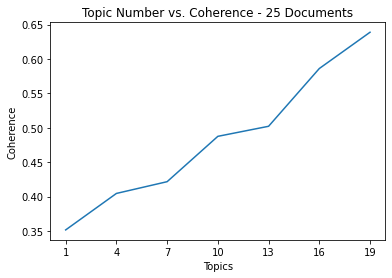

In [65]:
import matplotlib.pyplot as plt

df_results_25.sort_values(by="K", ascending=True, inplace=True)

fig, ax = plt.subplots()

ax.plot(df_results_25.K, df_results_25.coherence)
ax.set_xlabel("Topics")
ax.set_xticks(df_results_25.K)
ax.set_ylabel("Coherence")

ax.set_title("Topic Number vs. Coherence - 25 Documents")

fig.savefig("results/resultset_topicVariation_25-TopicVsCoherence.pdf")

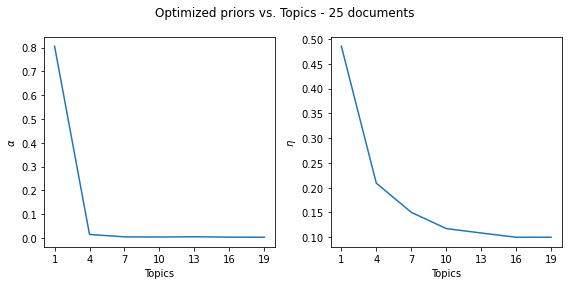

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
axes = axes.flatten()

df_results_25.sort_values(by="K", ascending=True, inplace=True)
axes[0].plot(df_results_25.K, df_results_25.alpha)
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("$\\alpha$")

df_results_25.sort_values(by="K", ascending=True, inplace=True)
axes[1].plot(df_results_25.K, df_results_25.eta)
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("$\eta$")

for ax in axes:
    ax.set_xticks(df_results_25.K)
    
fig.suptitle("Optimized priors vs. Topics - 25 documents")

plt.tight_layout()

fig.savefig("results/resultset_topicVariation_25-TopicVsOptPriors.pdf")

In [35]:
df_results_50 = pd.read_csv("results/resultset_topicVariation_50.csv")
df_results_50.sort_values(by="coherence", ascending=False)

,N,K,alpha,eta,elbo,coherence,topics,weights
5,50,16,0.005973,0.100000,74611.843750,0.429713,"[['neuron', 'word', 'network', 'rate', 'input'...","[[0.017381677, 0.009928102, 0.0097728195, 0.00..."
2,50,7,0.008261,0.138435,71786.710938,0.417035,"[['network', 'learning', 'neural', 'dropout', ...","[[0.013721937, 0.012301974, 0.007967052, 0.007..."
4,50,13,0.003404,0.100000,69713.257812,0.410035,"[['model', 'reward', 'learning', 'cache', 'fun...","[[0.023894232, 0.013158879, 0.011399826, 0.009..."
1,50,4,0.015376,0.185546,65973.710938,0.393375,"[['model', 'data', 'method', 'problem', 'funct...","[[0.010973792, 0.0090039885, 0.006448609, 0.00..."
6,50,19,0.006242,0.100000,75169.656250,0.391049,"[['data', 'missing', 'variable', 'harmony', 't...","[[0.018523274, 0.014958474, 0.01353298, 0.0116..."
3,50,10,0.006867,0.115626,71214.015625,0.387275,"[['dropout', 'bound', 'probability', 'paramete...","[[0.015388878, 0.01242042, 0.011121718, 0.0091..."
0,50,1,0.079565,0.256711,66543.000000,0.378596,"[['model', 'function', 'network', 'learning', ...","[[0.009019472, 0.007822197, 0.00744305, 0.0067..."


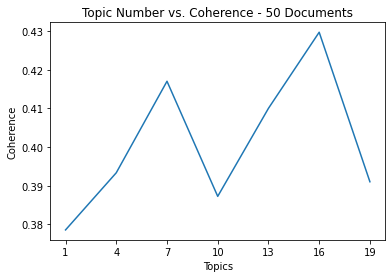

In [67]:
import matplotlib.pyplot as plt

df_results_50.sort_values(by="K", ascending=True, inplace=True)

fig, ax = plt.subplots()

ax.plot(df_results_50.K, df_results_50.coherence)
ax.set_xlabel("Topics")
ax.set_xticks(df_results_50.K)
ax.set_ylabel("Coherence")

ax.set_title("Topic Number vs. Coherence - 50 Documents")

fig.savefig("results/resultset_topicVariation_50-TopicVsCoherence.pdf")

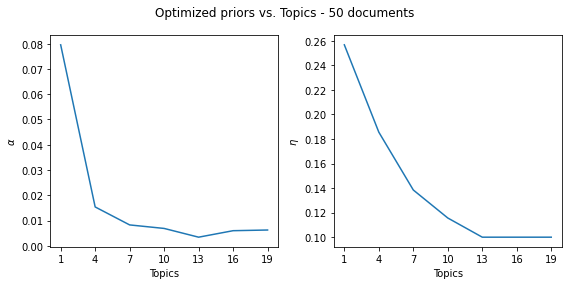

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
axes = axes.flatten()

df_results_50.sort_values(by="K", ascending=True, inplace=True)
axes[0].plot(df_results_50.K, df_results_50.alpha)
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("$\\alpha$")

df_results_50.sort_values(by="K", ascending=True, inplace=True)
axes[1].plot(df_results_50.K, df_results_50.eta)
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("$\eta$")

for ax in axes:
    ax.set_xticks(df_results_50.K)
    
fig.suptitle("Optimized priors vs. Topics - 50 documents")

plt.tight_layout()

fig.savefig("results/resultset_topicVariation_50-TopicVsOptPriors.pdf")

In [ ]:
# MAX_IT = 10
# EPS = 0.001
# tf.executing_eagerly()
# optim = tf.keras.optimizers.Adam(1e-3)
# # B = ed.Dirichlet(concentration=tf.fill([K, V], 0.1), name="topics")
# # Z = ed.DirichletMultinomial(tf.convert_to_tensor(Ns), concentration=tf.fill([D, K], 0.1))
# alpha = np.copy(alpha_n).astype(np.float32)
# eta = np.copy(eta_n).astype(np.float32)

# beta = np.copy(beta_n).astype(np.float32)
# phi = [np.full((n, K), 1/K).astype(np.float32) for n in Ns]
# gamma = np.copy(gamma_n).astype(np.float32)
# lmbd = np.copy(lmbd_n).astype(np.float32)

# bb = None
# gg = None
# ww = None

# class Positive(tf.keras.constraints.Constraint):
#     def __call__(self, w):
#         return w * tf.cast(tf.math.greater(w, 0.), w.dtype)

# bb = []
# for it in trange(MAX_IT):
#     bb2 = []
#     gg2 = []
#     ww2 = []
#     print('before', gamma)
#     for d in range(D):
#         for n in range(Ns[d]):
#             for i in range(K):
#                 phi[d][n, i] = beta[i, data_enc.iloc[d][n]] * np.exp(digamma(gamma[d, i]) - digamma(np.sum(gamma[d])))
#         phi[d] /= np.sum(phi[d], axis=-1, keepdims=True) + 1e-5
        
#         for i in range(K):
#             gamma[d, i] = alpha[i] + np.sum(phi[d][:, i])
#     print('after', gamma)

#     lmbd = np.full((K, V), eta)
#     for i in range(K):
#         for j in range(V):
#             for d in range(D):
#                 mask = (data_enc.iloc[d] == j)
#                 lmbd[i, j] += np.sum(phi[d][:, i]*mask)
    
     
# #     if bb is None:
# #         bb = bb2
# #         gg = gg2
# #         ww = ww2
# #         break
                
#     alpha_t = tf.Variable(alpha, trainable=True, constraint=Positive())
#     gamma_t = tf.convert_to_tensor(gamma, dtype=tf.float32)
    
    
#     def f_x():
#         g_term = tf.math.reduce_sum(tf.expand_dims((alpha_t - 1), 0)*(tf.math.digamma(gamma_t) - 
#                                                    tf.math.digamma(tf.math.reduce_sum(gamma_t, axis=1, keepdims=True))), axis=1)
#         loss = -tf.math.reduce_sum(tf.math.lgamma(tf.math.reduce_sum(alpha_t)) - tf.math.reduce_sum(tf.math.lgamma(alpha_t)) + g_term)
#         return loss
    
#     for itt in range(10):
#         for i in range(K):
#             for itt1 in range(50):
#                 #with tf.GradientTape() as tape:
#                 optim.minimize(f_x, [alpha_t])
# #                 grads = tape.gradient(loss, opt_a)
# #                 optim.apply_gradients([(grads, opt_a)])
#                 alpha[i] = alpha_t.numpy()[i]
#                 np.nan_to_num(alpha, copy=False, nan=1e-5)
#                 alpha_t.assign(alpha)
#         print(alpha_t)
#     beta = (lmbd - eta) / (np.sum(lmbd - eta, axis=-1, keepdims=True) + 1e-5)
#     break
    
#     eta_t = tf.Variable(eta, trainable=True, constraint=Positive())
    
#     @tf.function
#     def f_eta():
#         loss = K*((eta_t-1)*(tf.math.digamma(eta_t) - tf.math.digamma(eta_t*V)) + tf.math.lgamma(eta_t*V) - V*tf.math.lgamma(eta))
#         return loss
    
#     for itt1 in range(50):
#         optim.minimize(f_eta, [eta_t])
#     eta = eta_t.numpy()

    